In [1]:
import numpy as np

from pixell import enmap, enplot
from pixell.curvedsky import alm2cl, map2alm, alm2map, rand_map
from pixell.enmap import downgrade, upgrade

import matplotlib.pyplot as plt

from astropy.io import fits

data_base = '/home/aroman/data/'
data_dir = '/home/aroman/data/act_pub/'
cat_dir = data_dir + 'sz_cluster_hilton/'
cat_path = cat_dir + 'DR5_cluster-catalog_v1.1.fits'
cat_mask_path = cat_dir + 'DR5_cluster-search-area-mask_v1.0.fits'
map_ref_path = data_dir + 'act_planck_dr5.01_s08s18_AA_f090_daynight_map_srcfree.fits'
map_150_path = data_dir + 'act_planck_dr5.01_s08s18_AA_f150_daynight_map_srcfree.fits'
planck_mask_path = data_base + 'mask/planck_foreground_mask_GAL080.npy'

kpath = '/home/aroman/data/kendrick/01_act_ps_model_inputs/'

cl_camb = np.load(kpath + 'cl_camb.npy')

AM2RAD = 2.90888e-4
lmax = 10000

w_090_path = kpath + 'wfkp_90.fits'
w_150_path = kpath + 'wfkp_150.fits'

cat_mask = enmap.read_map(cat_mask_path, hdu=1)

# TSZ CLUSTER CAT DOWNGRADE
cat_mask_d40 = upgrade(downgrade(cat_mask, 40), 40)
cat_mask_d20 = upgrade(downgrade(cat_mask, 20), 20)

map_ref = enmap.read_map(map_ref_path)[0]
map_150 = enmap.read_map(map_150_path)[0]
w_090 = enmap.read_map(w_090_path)
w_150 = enmap.read_map(w_150_path)

planck_mask = enmap.read_map(planck_mask_path)

labels = ['ref T map', 'TSZ area map']
maps = [map_ref, cat_mask]


In [2]:
# tSZ aperture width
mf_width = (2.4 + 1) * AM2RAD # 2.4 arcmin filter plus 95% error bound in radians

def get_clusters(tsz_cat_path):
    ret = {}
    infields = ('decDeg', 'RADeg')
    outfields = ('dec', 'ra')
    coeffs = np.array((np.pi/180, np.pi/180))
    
    with fits.open(tsz_cat_path) as f:
        hdr = f[1].header
        cat = f[1].data

        for infield, outfield, c in zip(infields, outfields, coeffs):
            ret[outfield] = c * cat.field(infield)
    
    return ret

def pix_bounds_check(pix, shape):
    a = np.all(pix[:,0] >= 0) and np.all(pix[:,0] < shape[0])
    b = np.all(pix[:,1] >= 0) and np.all(pix[:,1] < shape[1])
    return a and b

def sky2pixint(sky, map_ref):
    # not sure why this isn't working!
    coords = [map_ref.sky2pix(sky_coord) for sky_coord in sky]
    return np.round(coords).astype(int)

def fill_between(map_t, left, right, c=1.):
    ar = np.array((left,right))
    
    l2 = np.min(ar, axis=0)
    r2 = np.max(ar, axis=0)
    
    for l,r in zip(l2, r2):
        map_t[l[0]:r[0], l[1]:r[1]] = c

def make_tsz_mask(tsz_cat_path, map_ref):
    ret = enmap.ndmap(np.ones(map_ref.shape), map_ref.wcs)
    
    clusters = get_clusters(tsz_cat_path)
    dec = clusters['dec']
    ra = clusters['ra']
    
    center = np.array((dec, ra)).T
    
    left = center - 0.5 * np.array([mf_width, mf_width])[None, :]
    right = center + 0.5 * np.array([mf_width, mf_width])[None, :]
    
    pix_l = sky2pixint(left, map_ref)
    pix_r = sky2pixint(right, map_ref)
    
    assert pix_bounds_check(pix_l, map_ref.shape) and pix_bounds_check(pix_r, map_ref.shape)
    
    fill_between(ret, pix_l, pix_r, 0.)
    
    return ret, np.array((dec,ra)).T

tsz_mask, clusters = make_tsz_mask(cat_path, map_ref)


Text(0, 0.5, '$C_l\\;l(l + 1)/2\\pi$')

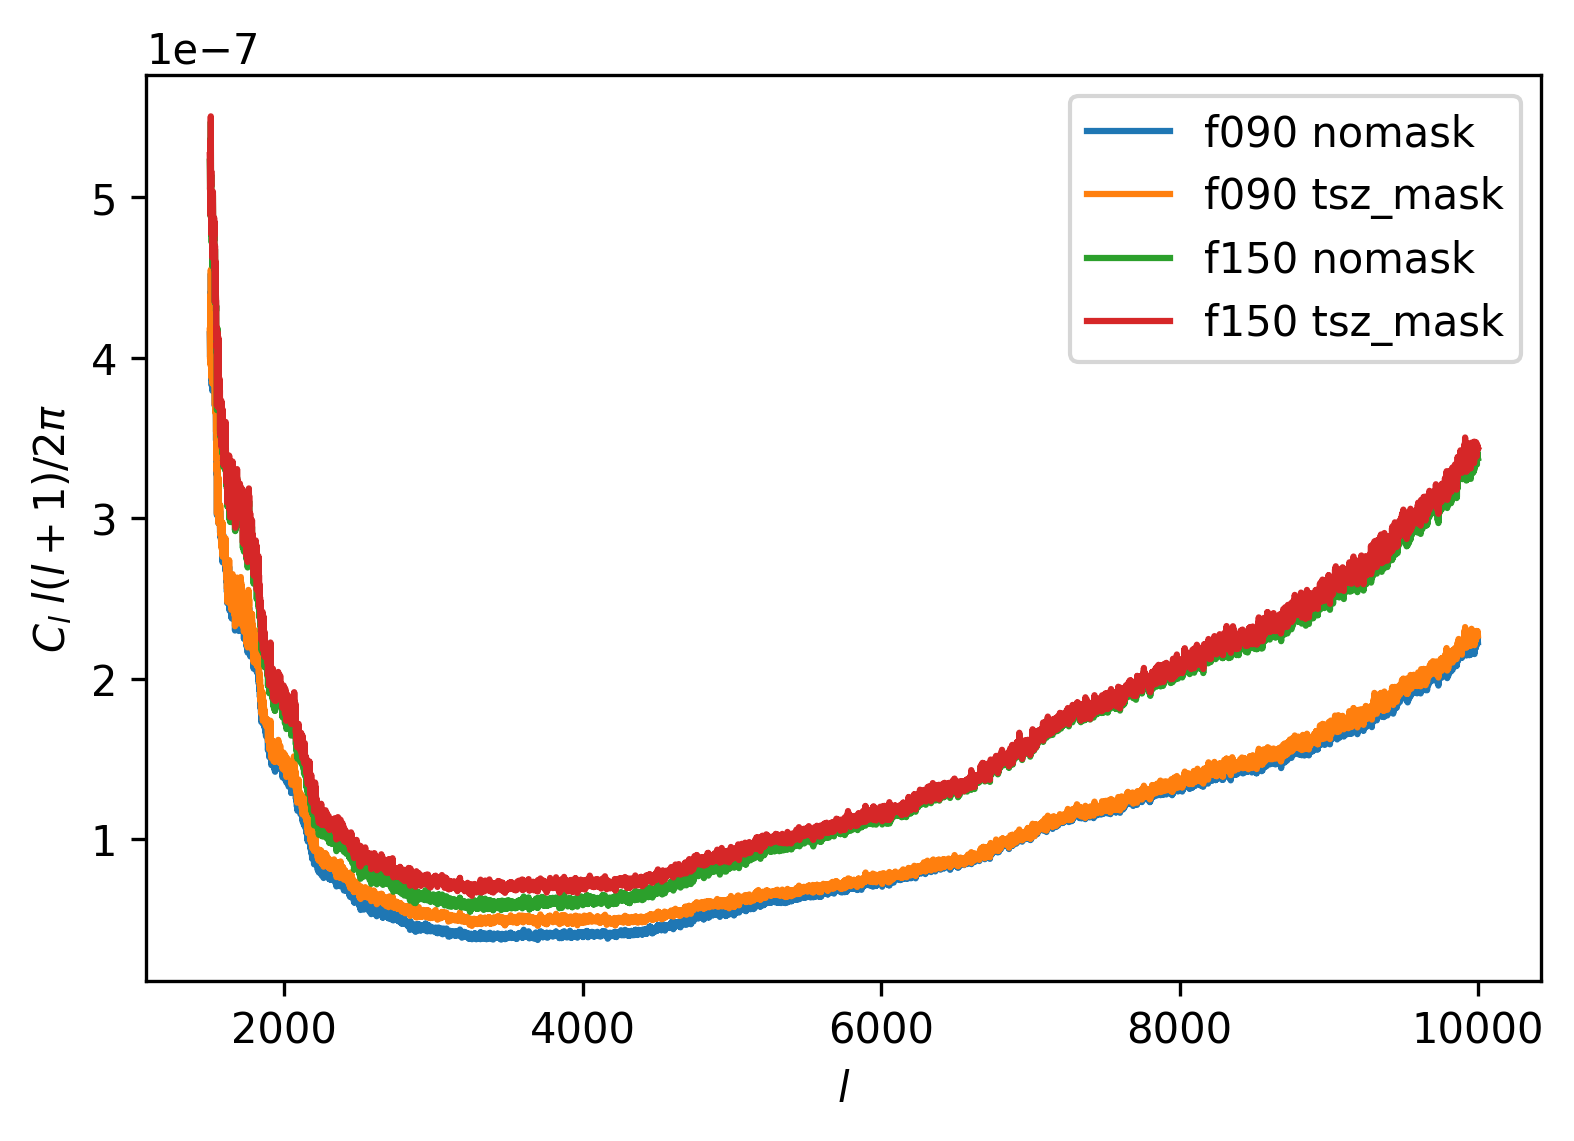

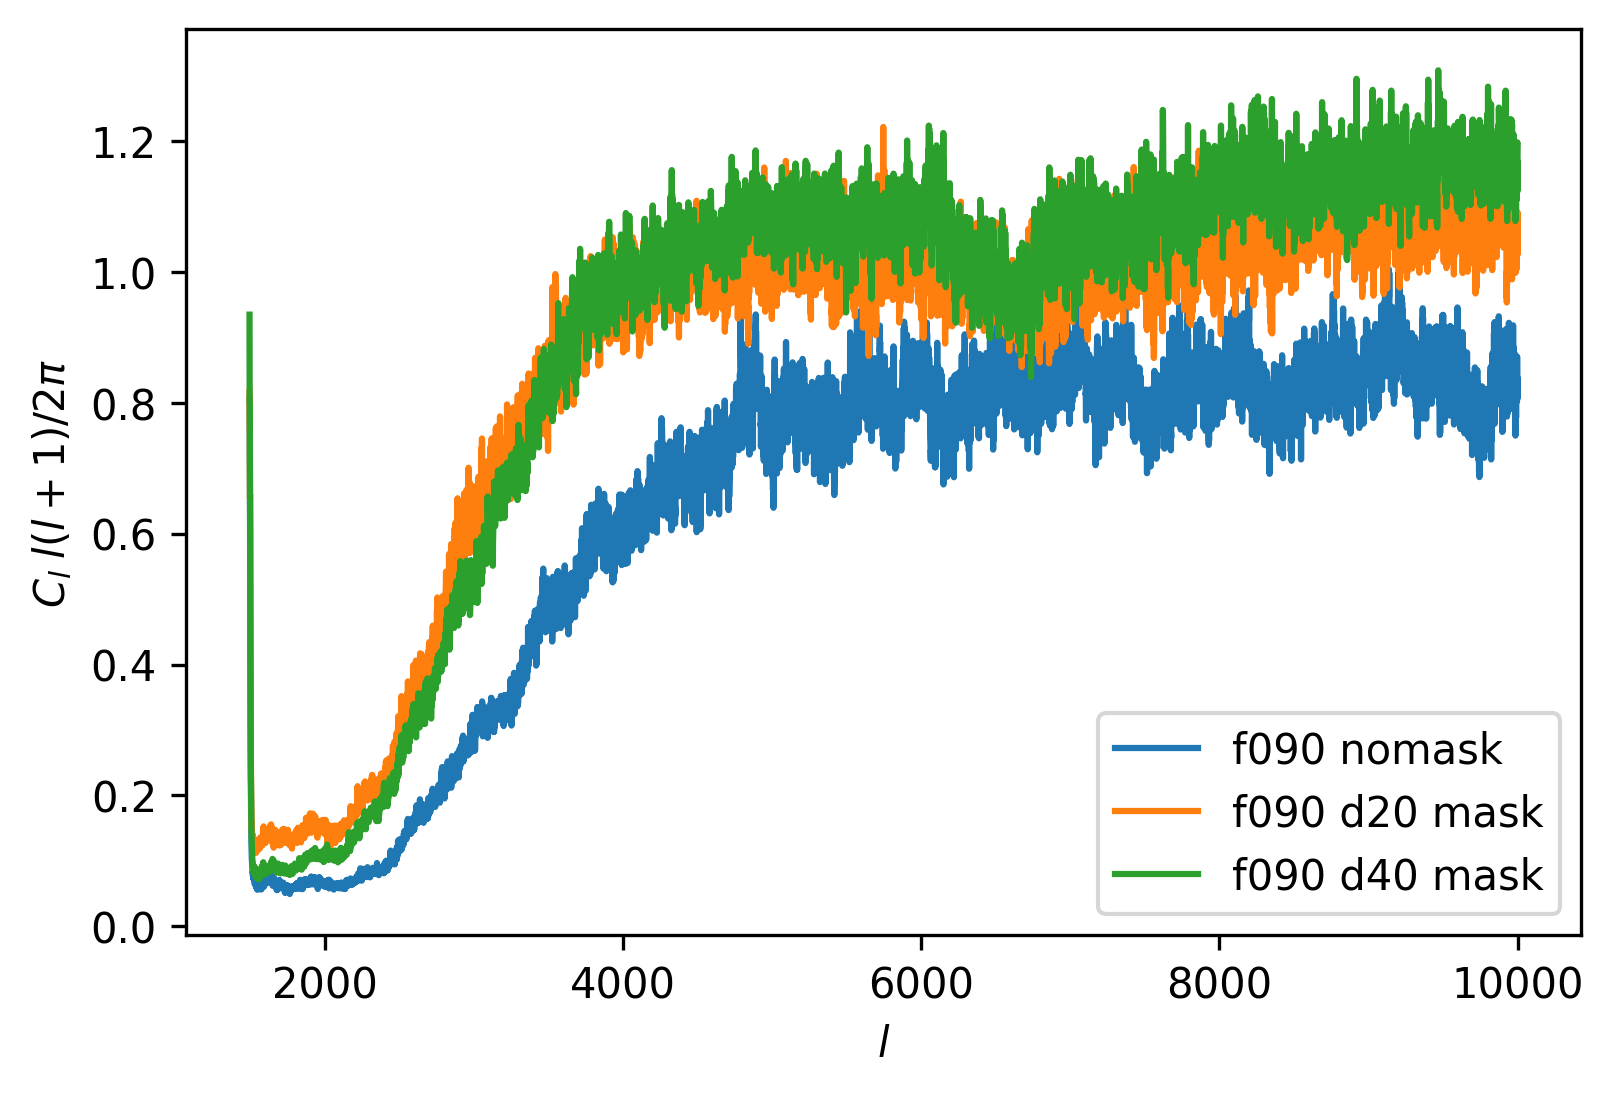

In [6]:
def map2pcl(map_t, lmax=lmax):
    return alm2cl(map2alm(map_t, lmax=lmax))

def rand2pcl(cl_in, mask):
    return map2cl(rand_map(cl_in) * mask)

def cl_leak_test(map_ref, weight, cl_ref, l_cut=1500, lmax=lmax):
    cl_in = cl_ref.copy()
    cl_in[l_cut:] = 0.
    
    rmap_a = rand_map(map_ref.shape, map_ref.wcs, cl_ref)
    rmap_b = rand_map(map_ref.shape, map_ref.wcs, cl_in)
    cl_a = map2pcl(rmap_a * weight, lmax)
    cl_b = map2pcl(rmap_b * weight, lmax)
    return cl_a, cl_b
    
def process_map(map_t, weight):
    return map_t * weight

m_090_nomask = w_090 * planck_mask * cat_mask_d40
m_090_mask = w_090 * tsz_mask * planck_mask * cat_mask_d40
m_090_mask_d20 = w_090 * tsz_mask * planck_mask * cat_mask_d20
m_150_nomask = w_150 * planck_mask * cat_mask_d40
m_150_mask = w_150 * tsz_mask * planck_mask * cat_mask_d40

w_090_nomask = m_090_nomask.sum()
w_090_mask = m_090_mask.sum()
w_150_nomask = m_150_nomask.sum()
w_150_mask = m_150_mask.sum()

# check for low -> high cl leaks

cl_nomask_090 = map2pcl(map_ref * m_090_nomask) / w_090_nomask
cl_mask_090 = map2pcl(map_ref * m_090_mask) / w_090_mask
cl_nomask_150 = map2pcl(map_ref * m_150_nomask) / w_150_nomask
cl_mask_150 = map2pcl(map_ref * m_150_mask) / w_150_mask

lmin_cut = 1500

cl_090_nomask_sim, cl_090_nomask_leak = cl_leak_test(map_ref, m_090_nomask, cl_camb, lmin_cut)
cl_090_d20_sim, cl_090_mask_d20_leak = cl_leak_test(map_ref, m_090_mask_d20, cl_camb, lmin_cut)
cl_090_d40_sim, cl_090_mask_leak = cl_leak_test(map_ref, m_090_mask, cl_camb, lmin_cut)

ells = np.arange(lmax + 1)
norm = ells * (ells + 1) / 2 / np.pi

lmin_plot = 1500

plt.figure(dpi=300, facecolor='w')
plt.plot(ells[lmin_plot:], (norm * cl_nomask_090)[lmin_plot:], label='f090 nomask')
plt.plot(ells[lmin_plot:], (norm * cl_mask_090)[lmin_plot:], label='f090 tsz_mask')
plt.plot(ells[lmin_plot:], (norm * cl_nomask_150)[lmin_plot:], label='f150 nomask')
plt.plot(ells[lmin_plot:], (norm * cl_mask_150)[lmin_plot:], label='f150 tsz_mask')
plt.legend()
plt.xlabel(r'$l$')
plt.ylabel(r'$C_l\;l(l + 1)/2\pi$')


cls = [cl_090_nomask_leak,
       cl_090_mask_d20_leak,
       cl_090_mask_leak]

cl_refs = [cl_090_nomask_sim,
           cl_090_d20_sim,
           cl_090_d40_sim]

cl_labels = ['f090 nomask',
             'f090 d20 mask',
             'f090 d40 mask']

plt.figure(dpi=300, facecolor='w')
for cl, cl_ref, label in zip(cls, cl_refs, cl_labels):
    plt.plot(ells[lmin_cut-5:], (cl / cl_ref)[lmin_cut-5:], label=label)
plt.legend()
plt.xlabel(r'$l$')
plt.ylabel(r'$C_l\;l(l + 1)/2\pi$')


car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[21601.00,7561.00]}
1517


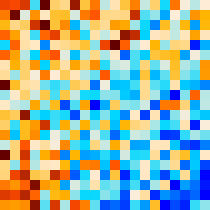

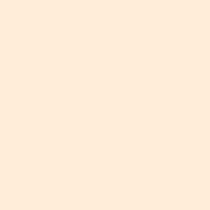

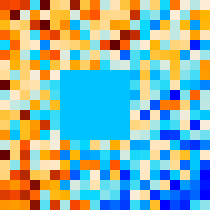

1185


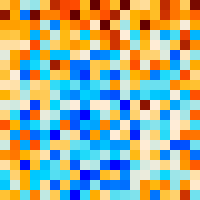

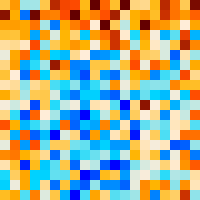

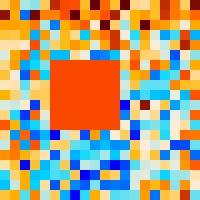

2104


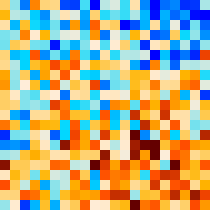

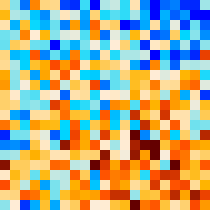

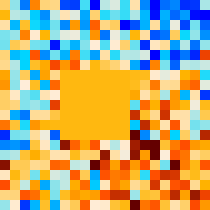

1719


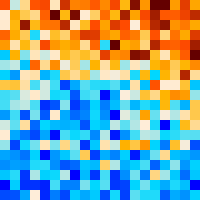

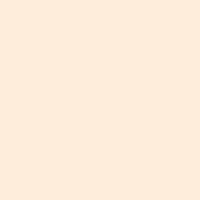

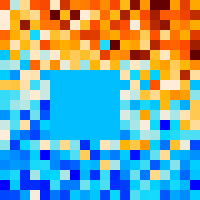

1416


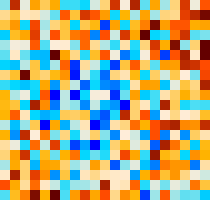

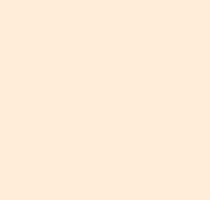

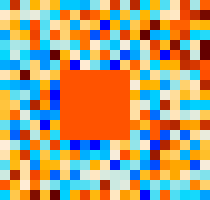

2938


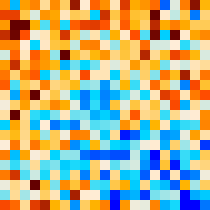

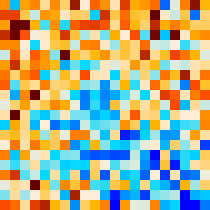

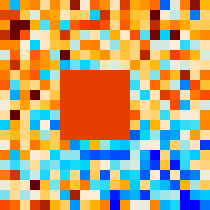

2136


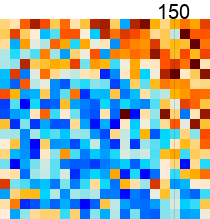

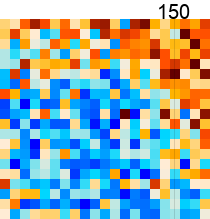

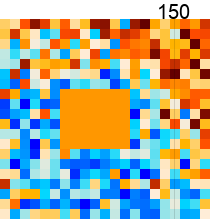

2556


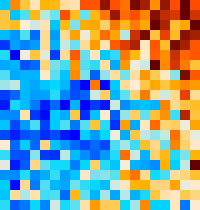

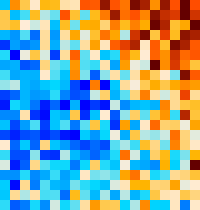

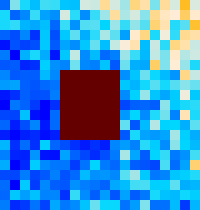

2524


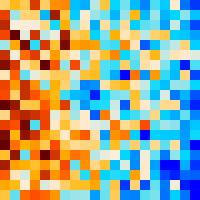

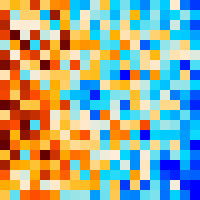

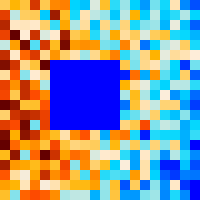

2855


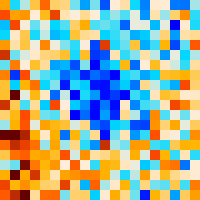

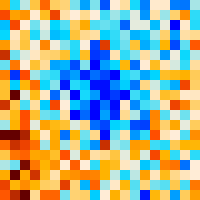

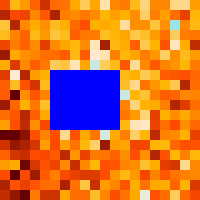

2424


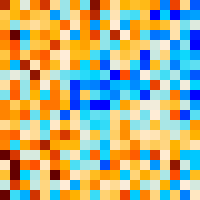

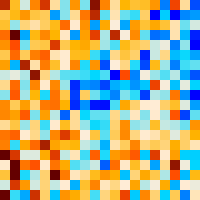

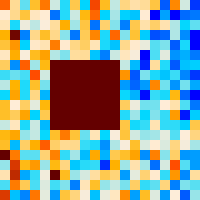

1658


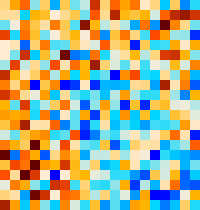

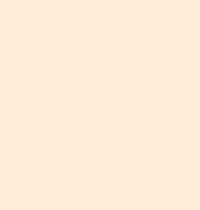

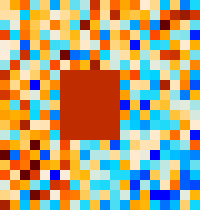

1683


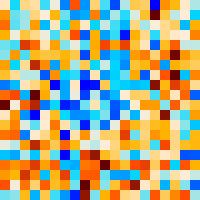

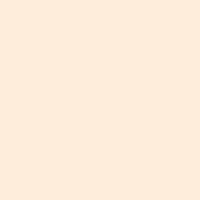

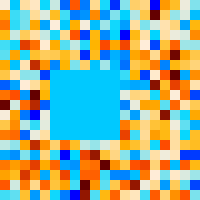

1134


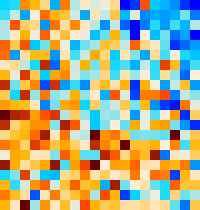

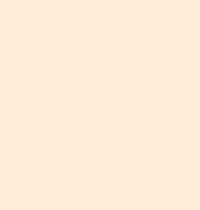

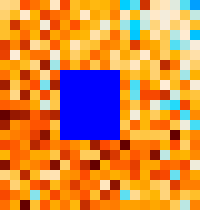

1246


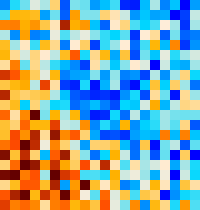

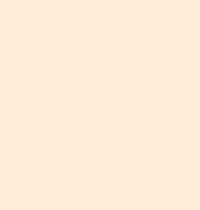

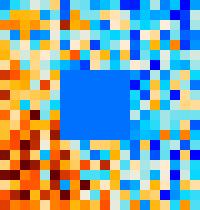

1190


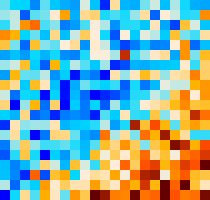

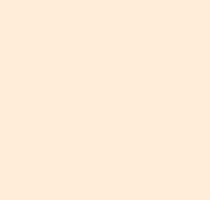

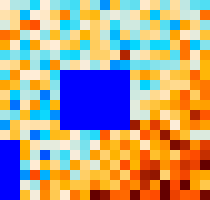

In [4]:
# dtheta = 0.25 * 0.5 * np.pi / 180
wcs = map_ref.wcs
print(wcs)


dtheta = 1.5 * mf_width

# submask = map_ref.submap([left, right])
# print(submask.shape)

# labels = ['ref T map', 'TSZ area map', 'TSZ cluster mask']
# maps = [map_ref, cat_mask, mask]
# dgs = [15,15,15,1]

# for map_t, label, dg in zip(maps, labels, dgs):
#     print(label)
#     fig = enplot.plot(downgrade(map_t, dg), ticks=15)
#     enplot.show(fig)

for iind in np.random.randint(2000, size=16) + 1000:
    pos_center = clusters[iind]
    left = pos_center - dtheta
    right = pos_center + dtheta
    print(iind)
    sm = map_ref.submap([left, right])
    sm2 = (map_ref * w_090 * planck_mask).submap([left, right])
    sm3 = (map_ref * tsz_mask).submap([left, right])
    
    fig = enplot.plot(upgrade(sm,10), ticks=15)
    enplot.show(fig)
    fig = enplot.plot(upgrade(sm2,10), ticks=15)
    enplot.show(fig)
    fig = enplot.plot(upgrade(sm3,10), ticks=15)
    enplot.show(fig)